In this notebook we will look into the revenue level and take rate of each industry to select the top 3 industries from which the top 100 merchants will be selected

In [1]:
import os
import sys  
from pathlib import Path
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)
import seaborn as sns

from scripts.constants import *
from scripts.plotting import *
from scripts.misc_changes import *

import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import col, mean, median



In [2]:
spark = create_spark()

your 131072x1 screen size is bogus. expect trouble
23/10/13 13:16:08 WARN Utils: Your hostname, DESKTOP-IUQJ8D5 resolves to a loopback address: 127.0.1.1; using 172.23.100.88 instead (on interface eth0)
23/10/13 13:16:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 13:16:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/13 13:16:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
PREFIX =  "."

In [4]:
# mapped_industry.csv contains all the merchants and the industry they belong to

df = spark.read.csv(PREFIX + INDUSTRY_MAPPING_PATH, header=True, inferSchema=True)

In [5]:
# shows the tags of each industry

unique_rows = df.select(INDUSTRY_TAGS, MAPPED_INDUSTRY).distinct().orderBy(MAPPED_INDUSTRY)
unique_rows

industry_tags,MappedIndustry
jewelry watch clo...,A
shoe,B
computer programm...,C
stationery office...,D
artist supply craft,E
digital goods boo...,F
books periodicals...,G
motor vehicle new...,H
opticians optical...,I
computers compute...,J


In [6]:
def categorise_industry(sdf: DataFrame) -> dict:
    """
    Categoriese the merchants by their respective industry
    - Parameters
        - sdf: spark dataframe contains information about the merchant and its industry
    - Returns
        - Dictionary containing the induustries as the key and merchnat information as the value
    """
    industry_category = {}
    industry_list = sorted(df.select(MAPPED_INDUSTRY).distinct().collect())
    for row in industry_list:
        x = row[MAPPED_INDUSTRY]
        industry_category[x] = sdf.filter(df[MAPPED_INDUSTRY] == x)
    
    return industry_category

In [7]:
industry_dict = categorise_industry(df)

# Merchant Revenue 

In [8]:
revenue_dict = {}
revenue_lvl = ['a', 'b', 'c', 'd', 'e']

In [9]:
# for each industry, we are cummulating the number of merchants in each revenue level

for key, value in industry_dict.items():

    # grouping the merchants by revenue level for a given industry
    revenue = value.groupBy(REVENUE_LEVEL).count().orderBy(REVENUE_LEVEL)

    # gets the revenue level in each industry since not all industries has 5 levels 
    revenue_grp = revenue.select(REVENUE_LEVEL).collect()

    # for each revenue level in a given industry, we count the number of merchants
    # if a particular revenue level is not there, we store it with 0 count in the dict
    lst = []
    for x in revenue_lvl:
        for row in revenue_grp:
            y = row[REVENUE_LEVEL] 
            lst.append(y)

        if x not in lst:
            new_row = Row(REVENUE_LEVEL=x, count = 0)
            new_row_df = spark.createDataFrame([new_row])
            revenue = revenue.union(new_row_df)
        revenue = revenue.orderBy('count', ascending = False)

    value_revenue = revenue
    revenue_dict[key] = value_revenue
            

Getting the count of merchants in the different revenue level for each industry. Used for further analysis

In [10]:
revenueA = {}

for key, value in revenue_dict.items():
    revenueA[key] = value.filter(col(REVENUE_LEVEL) == revenue_lvl[0]).select("count").collect()[0][0]

sorted_revenueA = dict(sorted(revenueA.items(), key=lambda item: item[1], reverse=True))
print(sorted_revenueA.items())


dict_items([('F', 95), ('P', 86), ('B', 85), ('T', 85), ('E', 84), ('K', 84), ('M', 83), ('V', 81), ('C', 78), ('J', 78), ('U', 76), ('X', 72), ('W', 71), ('Y', 68), ('G', 63), ('N', 62), ('D', 56), ('I', 54), ('H', 53), ('O', 52), ('S', 39), ('R', 37), ('Q', 32), ('L', 20), ('A', 8)])


In [11]:
revenueB = {}

for key, value in revenue_dict.items():
    revenueB[key] = value.filter(col(REVENUE_LEVEL) == revenue_lvl[1]).select("count").collect()[0][0]

sorted_revenueB = dict(sorted(revenueB.items(), key=lambda item: item[1], reverse=True))
print(sorted_revenueB.items())

dict_items([('X', 66), ('J', 64), ('N', 62), ('G', 61), ('T', 61), ('H', 60), ('B', 59), ('Y', 57), ('I', 56), ('L', 56), ('P', 56), ('O', 55), ('U', 55), ('C', 54), ('R', 54), ('F', 53), ('K', 49), ('Q', 49), ('S', 49), ('W', 49), ('E', 48), ('D', 47), ('M', 45), ('V', 44), ('A', 42)])


In [12]:
revenueC = {}

for key, value in revenue_dict.items():
    revenueC[key] = value.filter(col(REVENUE_LEVEL) == revenue_lvl[2]).select("count").collect()[0][0]

sorted_revenueC = dict(sorted(revenueC.items(), key=lambda item: item[1], reverse=True))
print(sorted_revenueC.items())

dict_items([('E', 54), ('C', 47), ('D', 43), ('V', 42), ('U', 41), ('S', 40), ('F', 39), ('Y', 39), ('Q', 38), ('A', 37), ('B', 37), ('N', 36), ('P', 36), ('I', 35), ('G', 34), ('J', 34), ('K', 34), ('L', 34), ('M', 34), ('T', 33), ('X', 33), ('O', 31), ('W', 31), ('H', 30), ('R', 30)])


In [13]:
revenueD = {}

for key, value in revenue_dict.items():
    revenueD[key] = value.filter(col(REVENUE_LEVEL) == revenue_lvl[3]).select("count").collect()[0][0]

sorted_revenueD = dict(sorted(revenueD.items(), key=lambda item: item[1], reverse=True))
print(sorted_revenueD.items())

dict_items([('D', 11), ('C', 8), ('R', 7), ('U', 6), ('E', 5), ('F', 5), ('I', 5), ('K', 5), ('X', 5), ('A', 4), ('M', 4), ('O', 4), ('Q', 4), ('Y', 4), ('G', 3), ('J', 3), ('S', 3), ('H', 2), ('N', 2), ('P', 2), ('T', 2), ('W', 2), ('L', 1), ('V', 1), ('B', 0)])


In [14]:
revenueE = {}

for key, value in revenue_dict.items():
    revenueE[key] = value.filter(col(REVENUE_LEVEL) == revenue_lvl[4]).select("count").collect()[0][0]

sorted_revenueE = dict(sorted(revenueE.items(), key=lambda item: item[1], reverse=True))
print(sorted_revenueE.items())

dict_items([('H', 6), ('B', 4), ('C', 4), ('D', 4), ('F', 3), ('G', 3), ('K', 3), ('S', 3), ('E', 2), ('J', 2), ('N', 2), ('P', 2), ('Q', 2), ('U', 2), ('V', 2), ('X', 2), ('Y', 2), ('I', 1), ('L', 1), ('M', 1), ('R', 1), ('T', 1), ('A', 0), ('O', 0), ('W', 0)])


Distribution of Revenue Level

In [15]:
five_revenue = [revenueA, revenueB, revenueC, revenueD, revenueE]
sorted_five_revenue = [sorted_revenueA, sorted_revenueB, sorted_revenueC, sorted_revenueD, sorted_revenueE]
START_ARB = 'a'

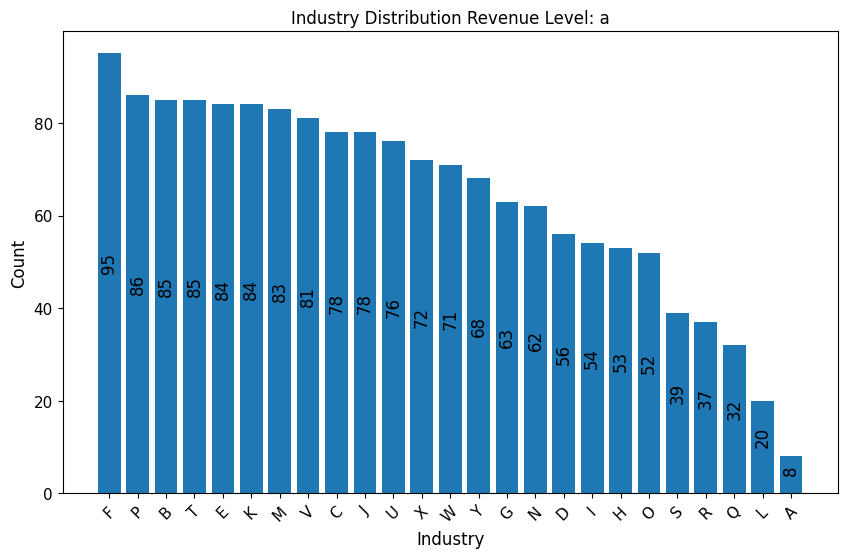

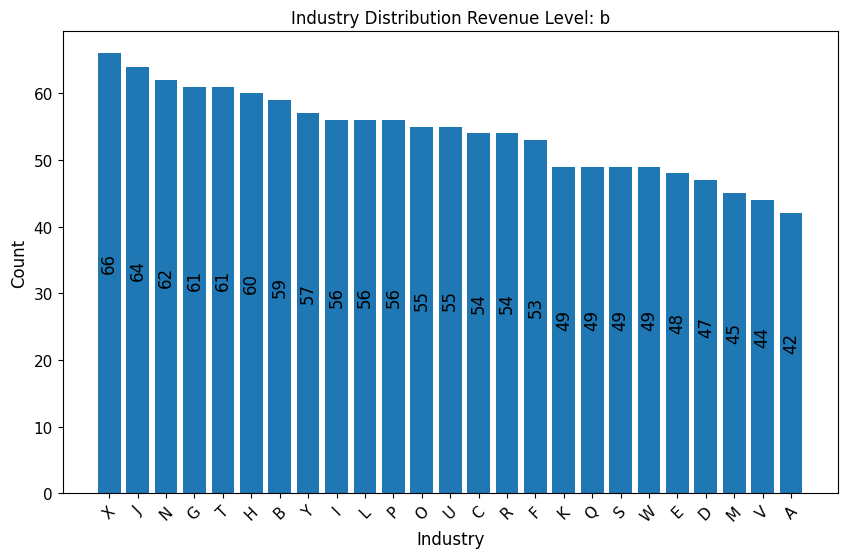

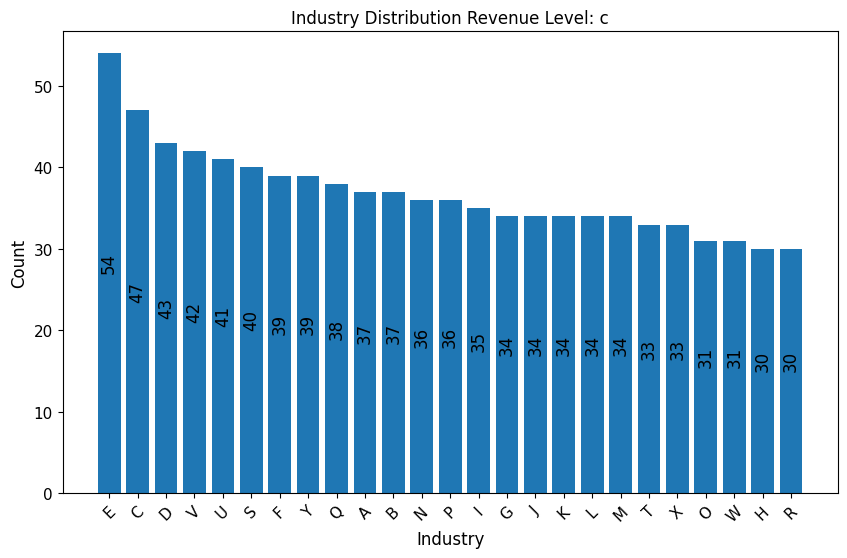

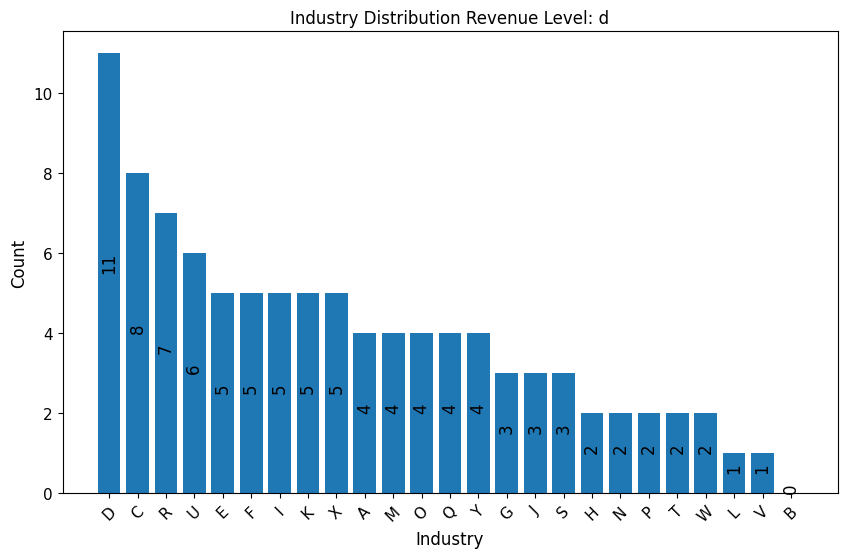

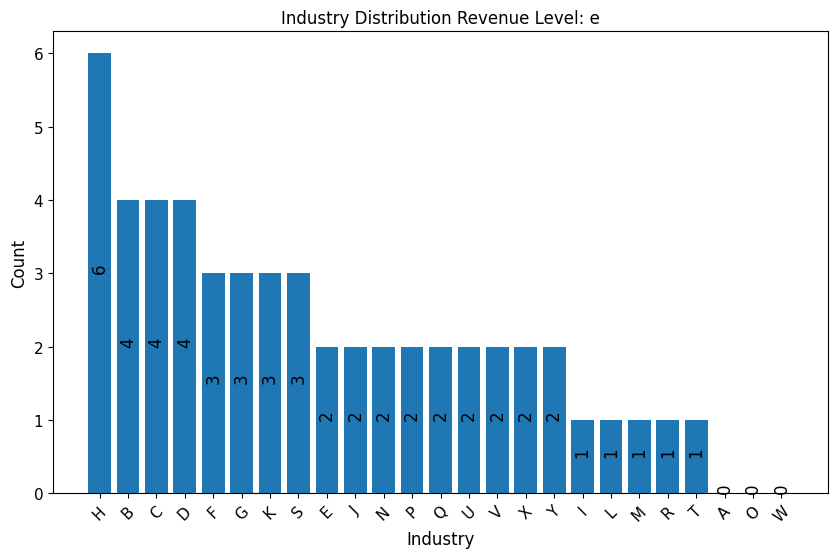

In [16]:
# visualising the distribution of differnet revenue level for each industry

for i, x in enumerate(sorted_five_revenue, 0):
    x_axis = list(x.keys())
    y_axis = list(x.values())

    df = pd.DataFrame(list(x.items()), columns=['Key', 'Value'])
    df = df.rename(columns={'Key': MAPPED_INDUSTRY, 'Value': f'Revenue_{chr(ord(START_ARB) + i)}_Count'})
    df.to_csv(f'../data/tables/revenue_{chr(ord(START_ARB) + i)}.csv', index=False)

    # adding freatures to the graph to make it more readable
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_axis, y_axis)
    for bar, value in zip(bars, y_axis):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(value), rotation= 90, ha='center', va='bottom', fontsize= 12)

    plt.xlabel('Industry', fontsize= 12)
    plt.ylabel('Count', fontsize= 12)
    plt.title(f'Industry Distribution Revenue Level: {chr(ord(START_ARB) + i)}')
    plt.xticks(rotation=45, fontsize= 11)
    plt.yticks(fontsize= 11)
    plt.savefig(f'../plots/industry_dist_revenue_{chr(ord(START_ARB) + i)}.png')
    plt.show()

In [17]:
# getting the count of the highest revenue level for a given industry\

highest_revenue = {}
for key, value in revenue_dict.items():
    highest = value.select('revenue_level').collect()[0][0]
    highest_revenue[key] = highest
print(highest_revenue.items())

dict_items([('A', 'b'), ('B', 'a'), ('C', 'a'), ('D', 'a'), ('E', 'a'), ('F', 'a'), ('G', 'a'), ('H', 'b'), ('I', 'b'), ('J', 'a'), ('K', 'a'), ('L', 'b'), ('M', 'a'), ('N', 'b'), ('O', 'b'), ('P', 'a'), ('Q', 'b'), ('R', 'b'), ('S', 'b'), ('T', 'a'), ('U', 'a'), ('V', 'a'), ('W', 'a'), ('X', 'a'), ('Y', 'a')])


In [18]:
revenue_count = {}

# Count the occurrences of each unique value in the dictionary
for value in highest_revenue.values():
    if value in revenue_count:
        revenue_count[value] += 1
    else:
        revenue_count[value] = 1

revenue_count

{'b': 9, 'a': 16}

From the above output, we can see that most of the industry has merchats in the revenue level 'a' and we can also notice that the industry H is the only industry with 6 mercants (the highest number of merchants) in the revenue level 'e'.  

# Merchant Takerate

In [19]:
def distribution_takerate(industry: str, sdf: DataFrame):
    """
    Plot the distribution of takerate for the industry
    - Parameters
        - industry: string which indicates the industry we are ploting the take rate for
        - sdf     : dataframe containg the takerate of the merchants of the industry
    - Returns
        - A plot showing the takerate distribution of an indutry
    """

    df = sdf.toPandas()
    data = df[TAKE_RATE]
    plt.figure(figsize=(8, 6))
    sns.histplot(data, bins=20, kde=True, color='skyblue')

    plt.xlabel('Takerate')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Takerate of {industry}')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.savefig(f'../plots/takerate_of_{industry}.png')
    plt.show()


In [20]:
def distribution_takerate_log(industry: str, sdf: DataFrame):
    """
    Plot the distribution of log of the takerate for the industry
    - Parameters
        - industry: string which indicates the industry we are ploting the take rate for
        - sdf     : dataframe containg the takerate of the merchants of the industry
    - Returns
        - A plot showing the log(takerate) distribution of an indutry
    """
    
    df = sdf.toPandas()
    data = df[TAKE_RATE]
    data = np.log(data)
    plt.figure(figsize=(8, 6))
    sns.histplot(data, bins=20, kde=True, color='skyblue')

    plt.xlabel('Takerate')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of log(Takerate) of {industry}')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()

    plt.show()

Distribution of take rate for every industry

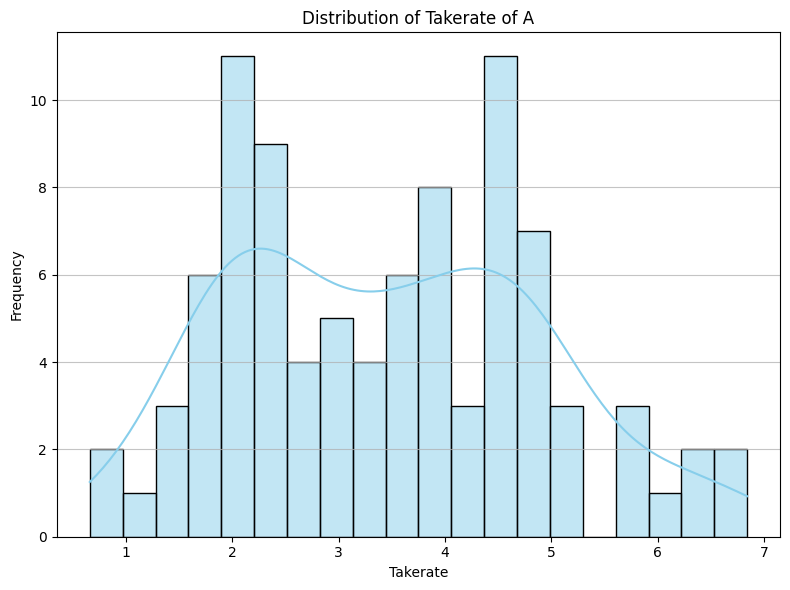

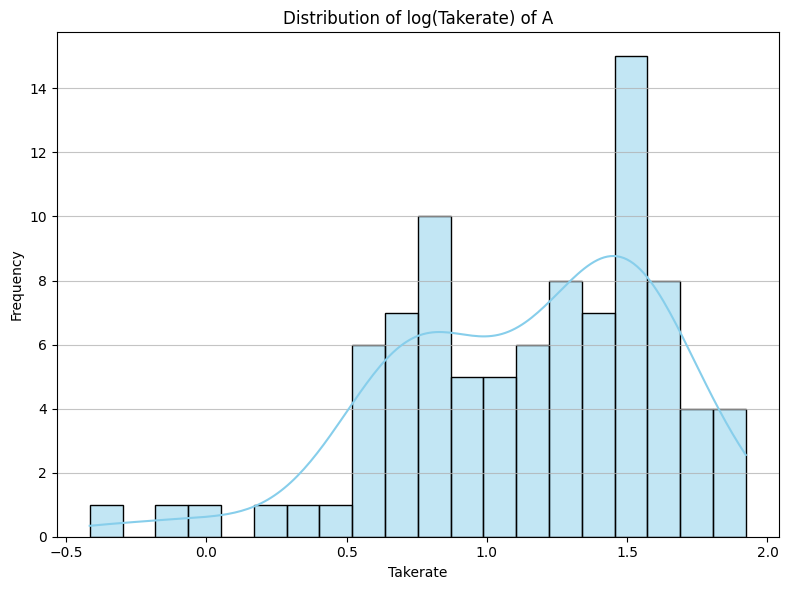

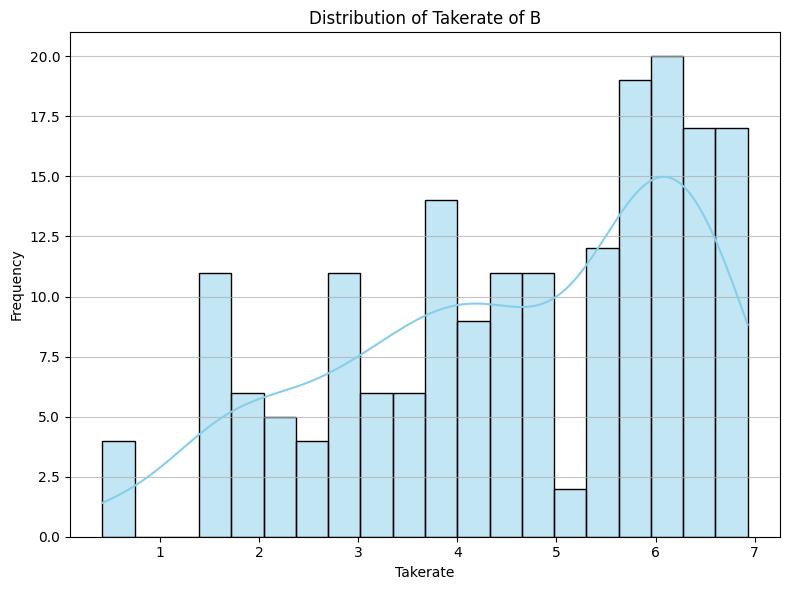

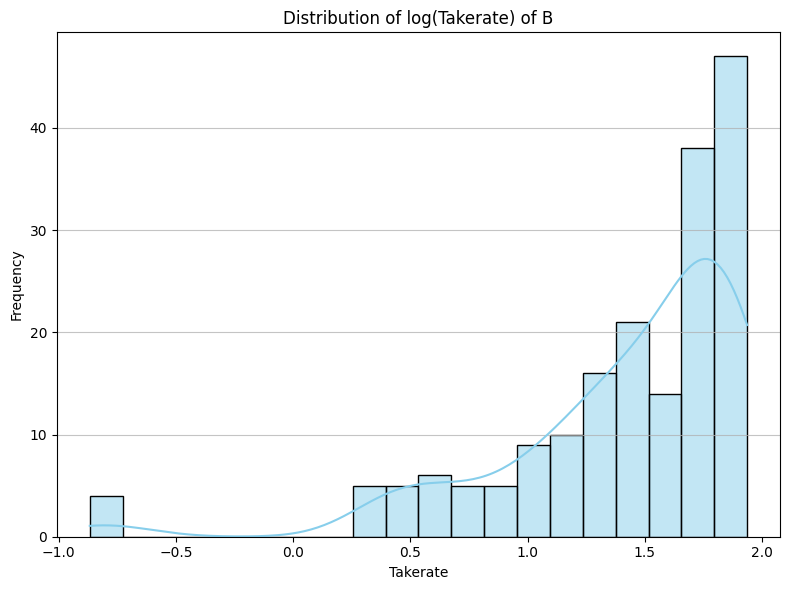

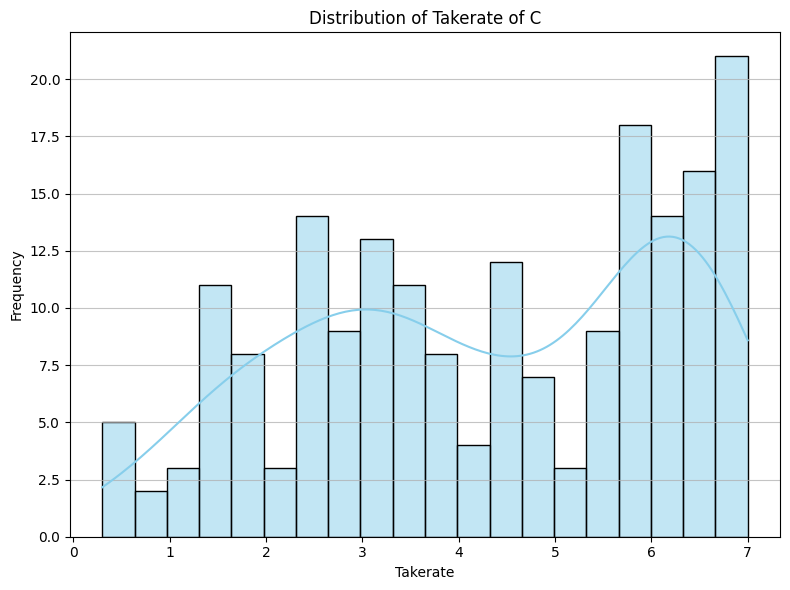

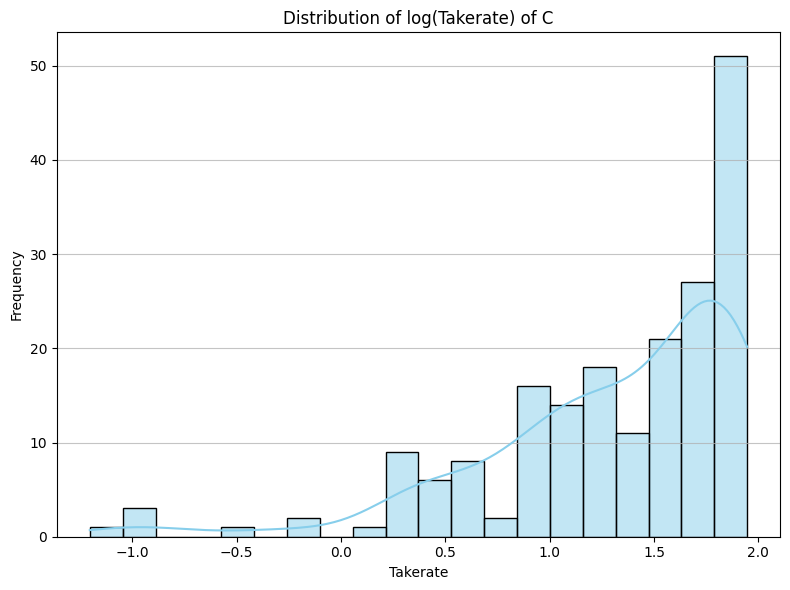

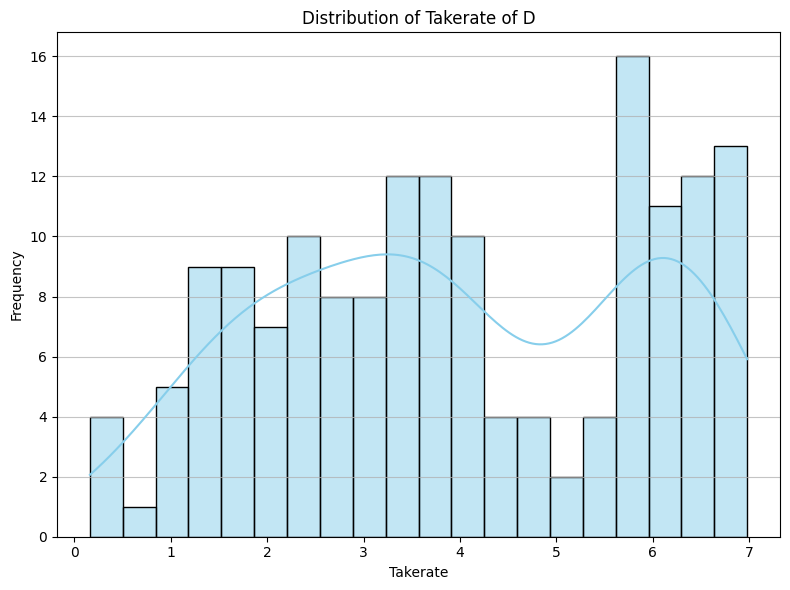

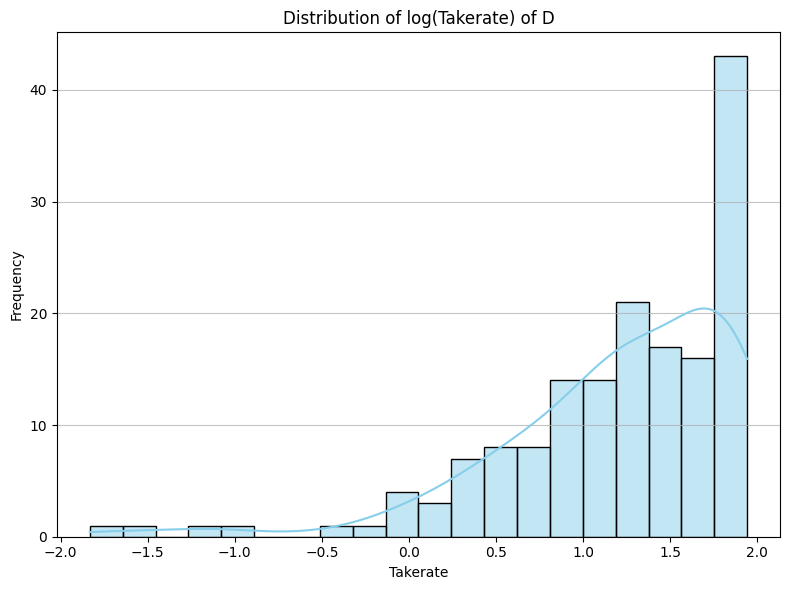

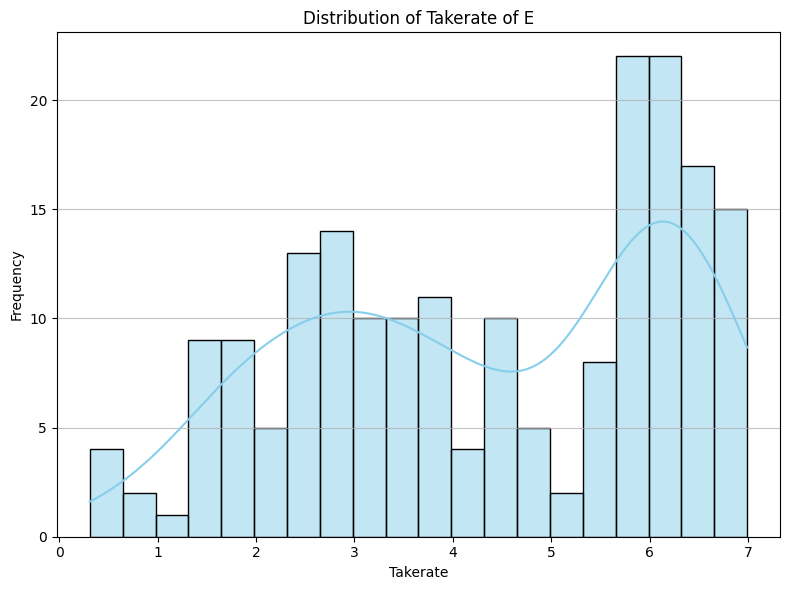

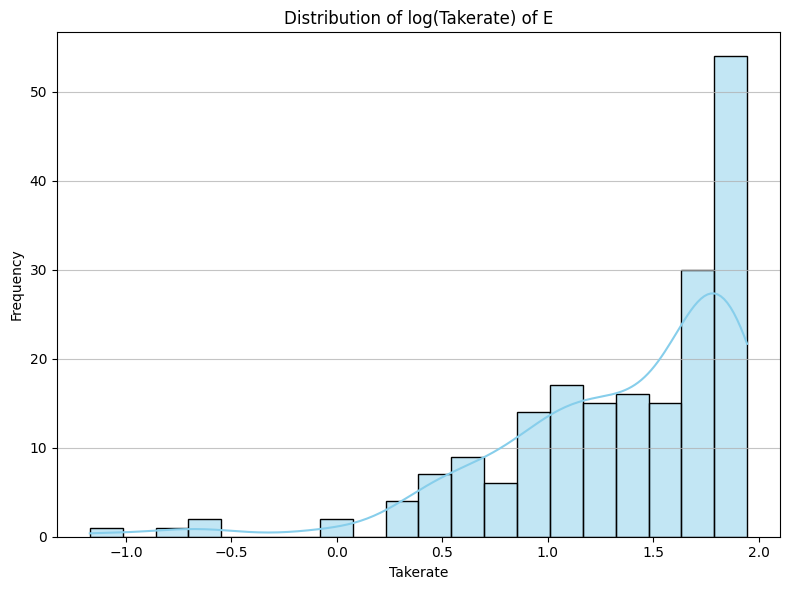

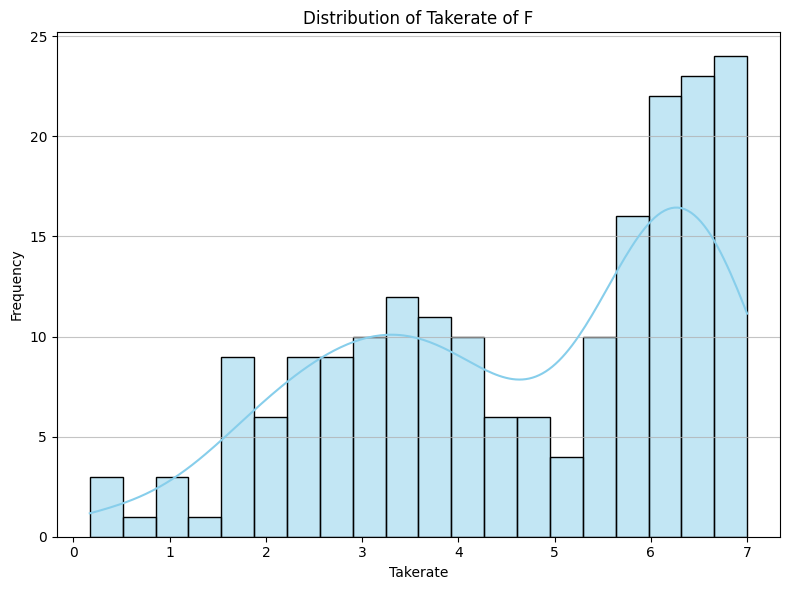

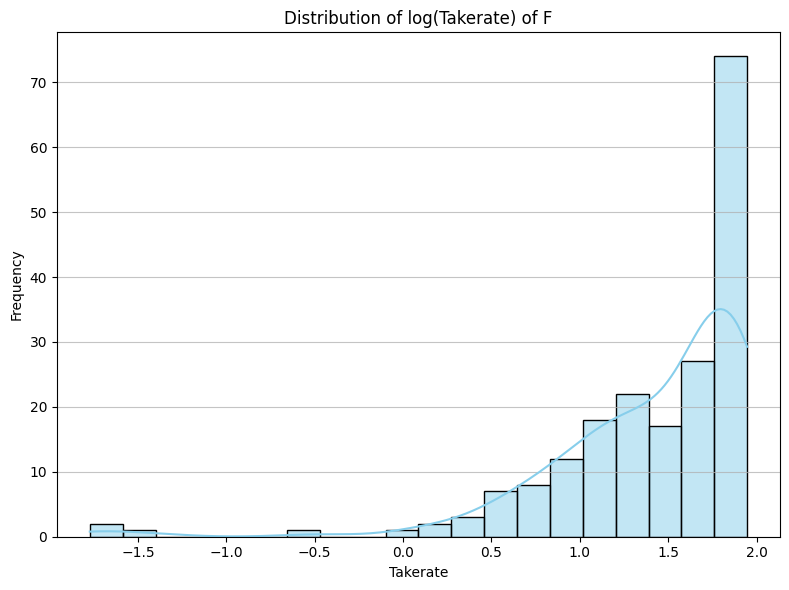

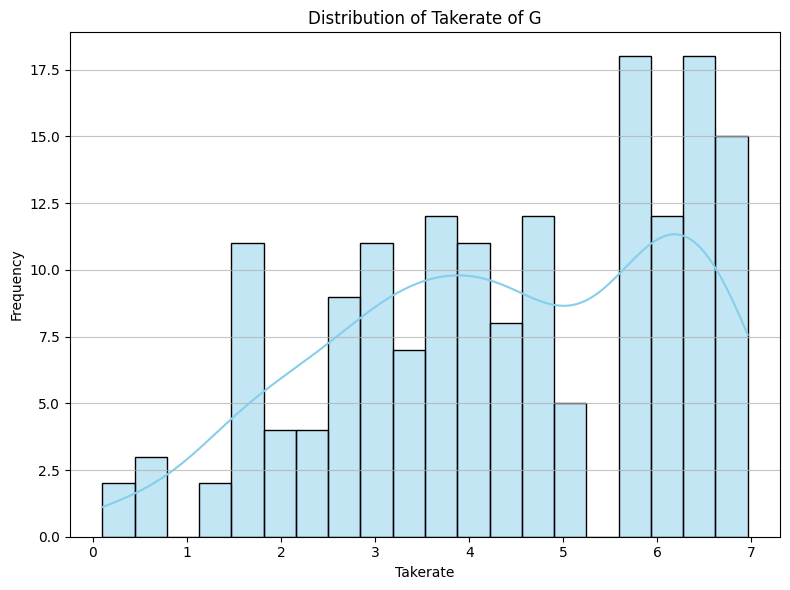

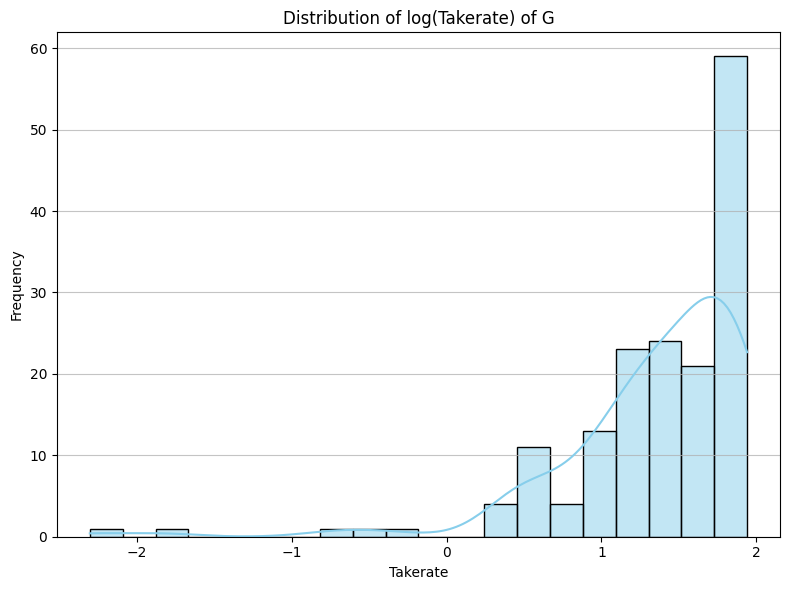

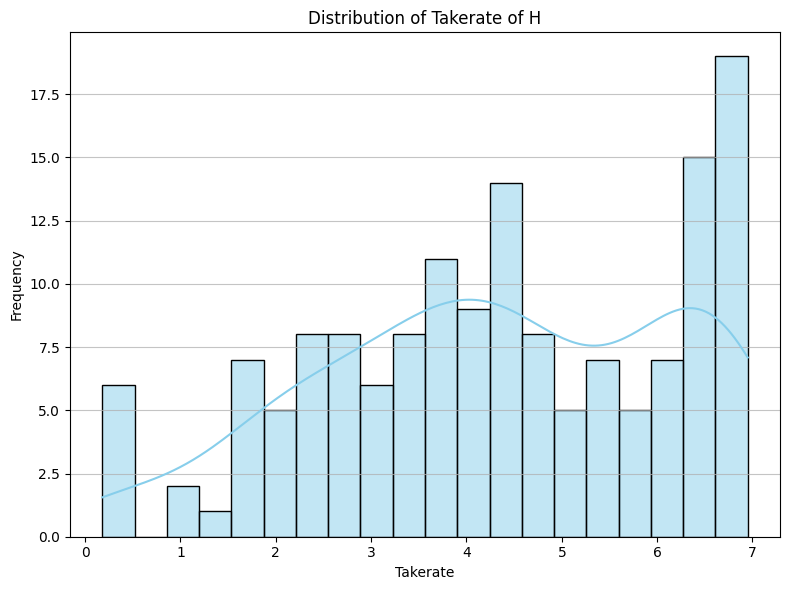

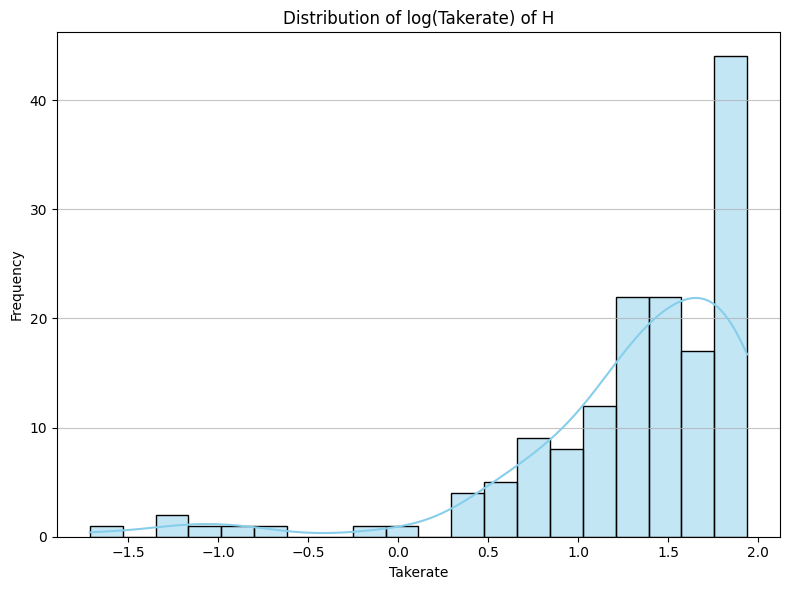

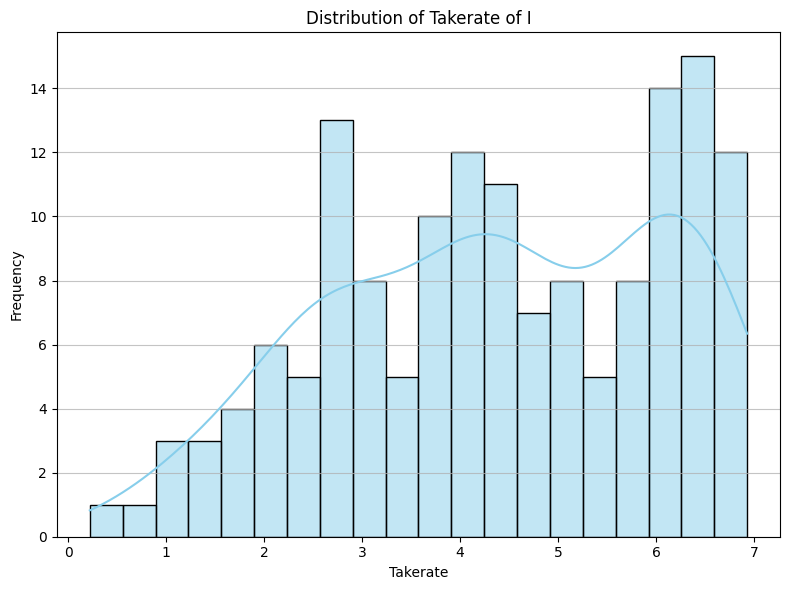

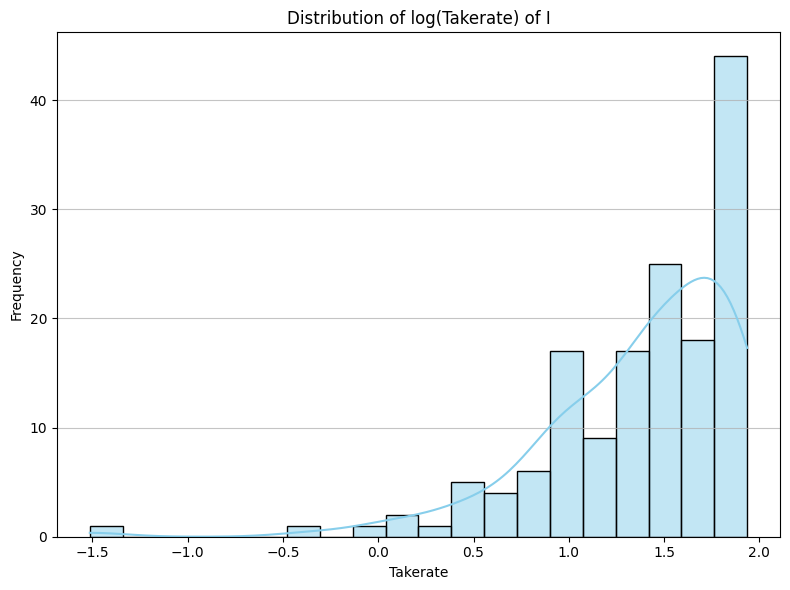

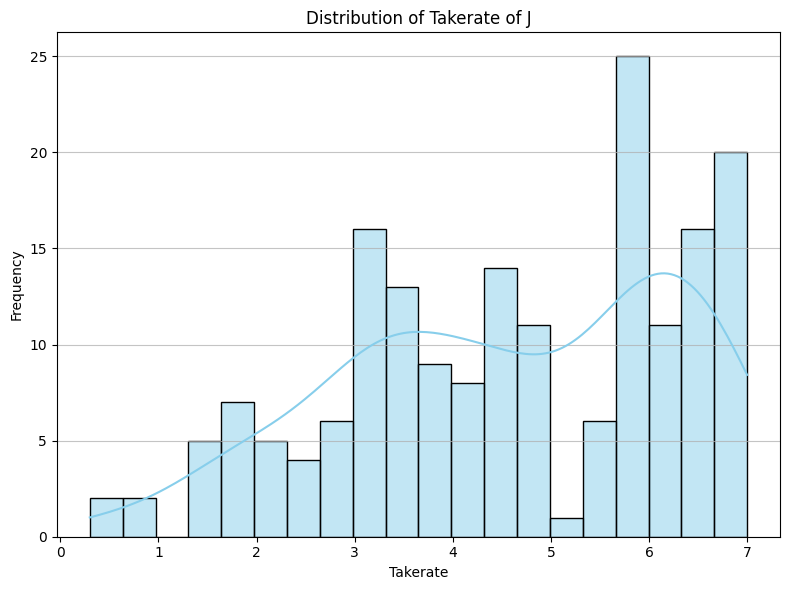

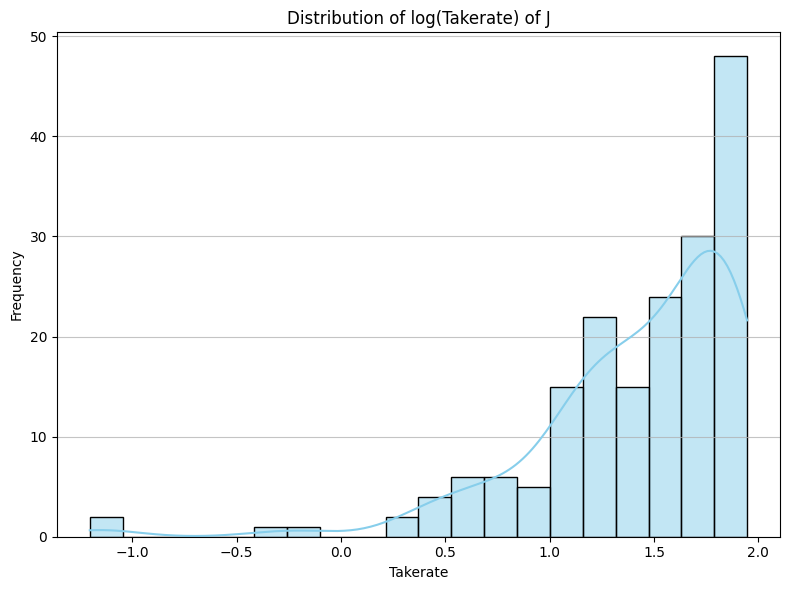

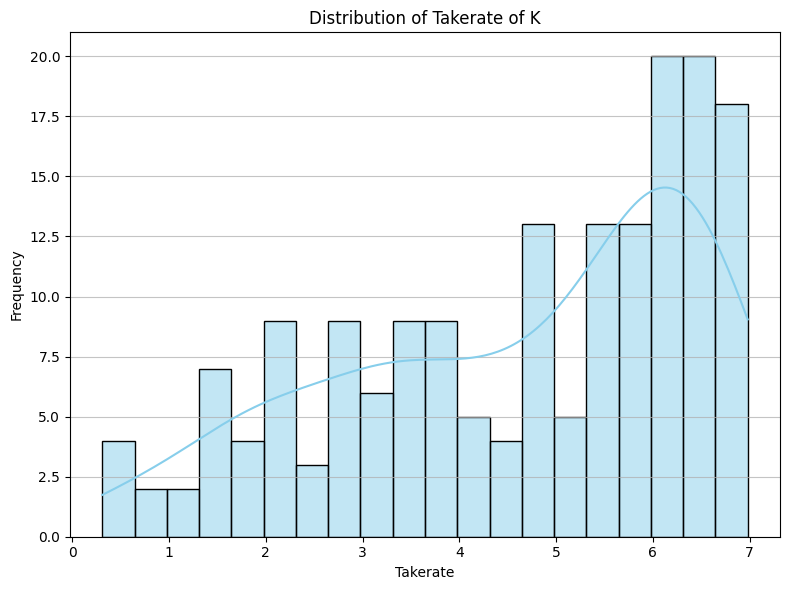

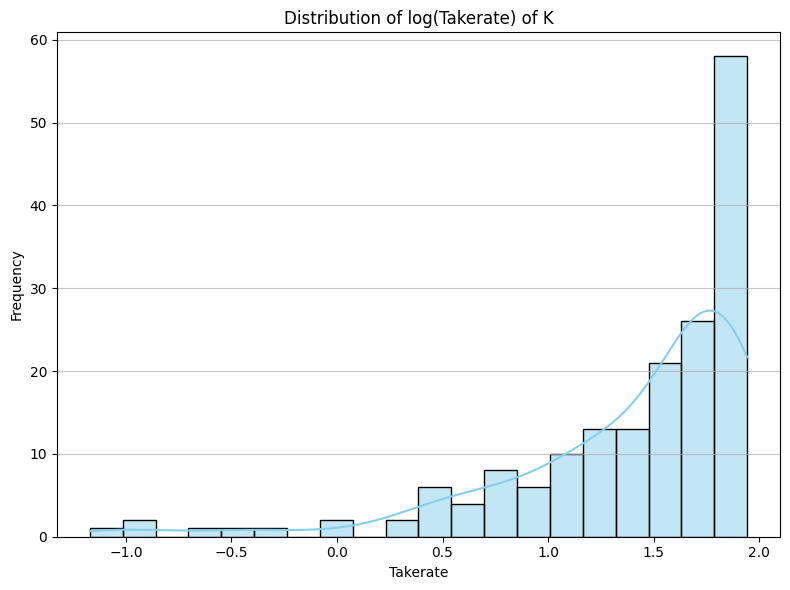

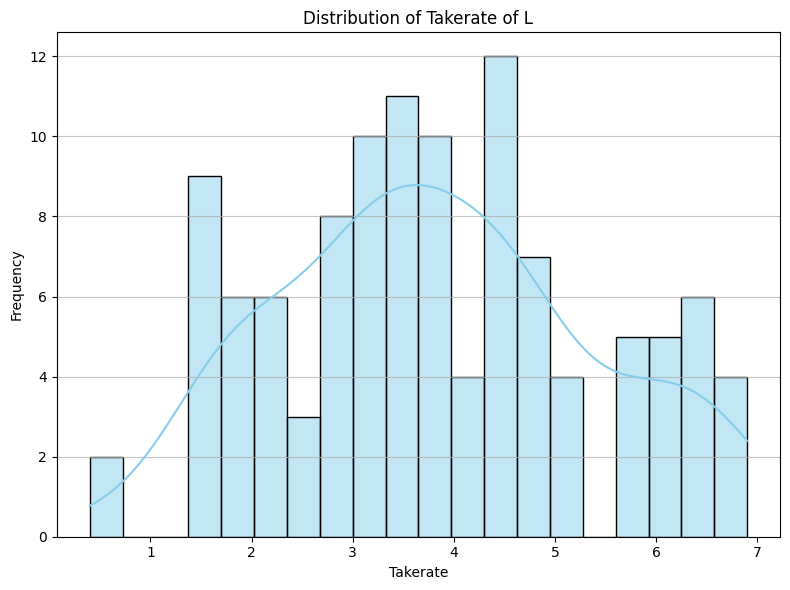

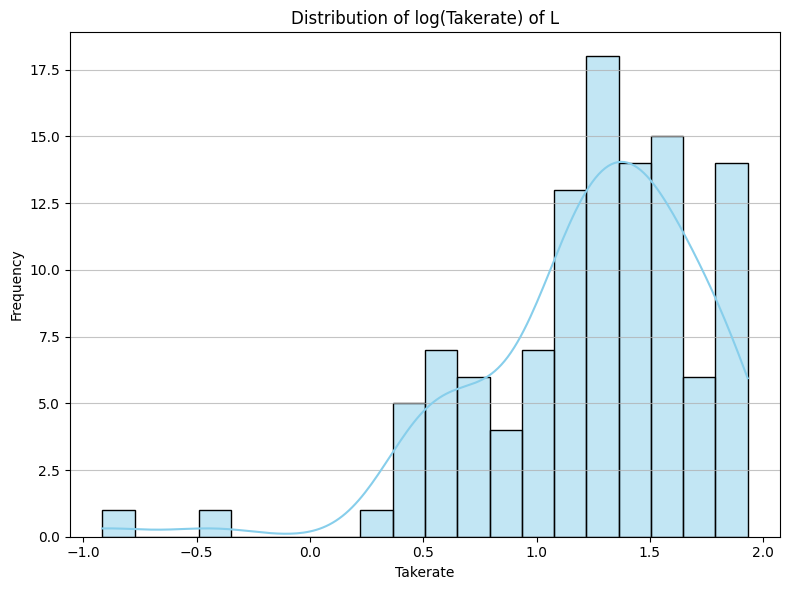

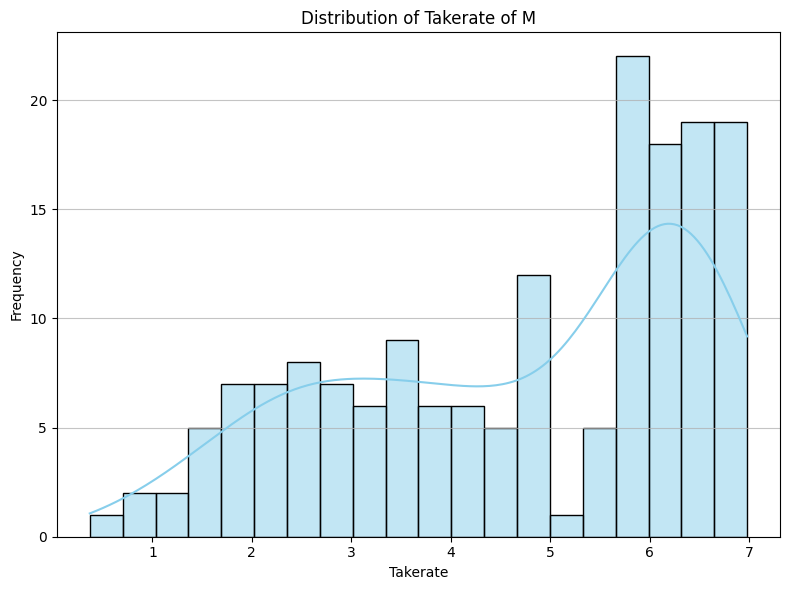

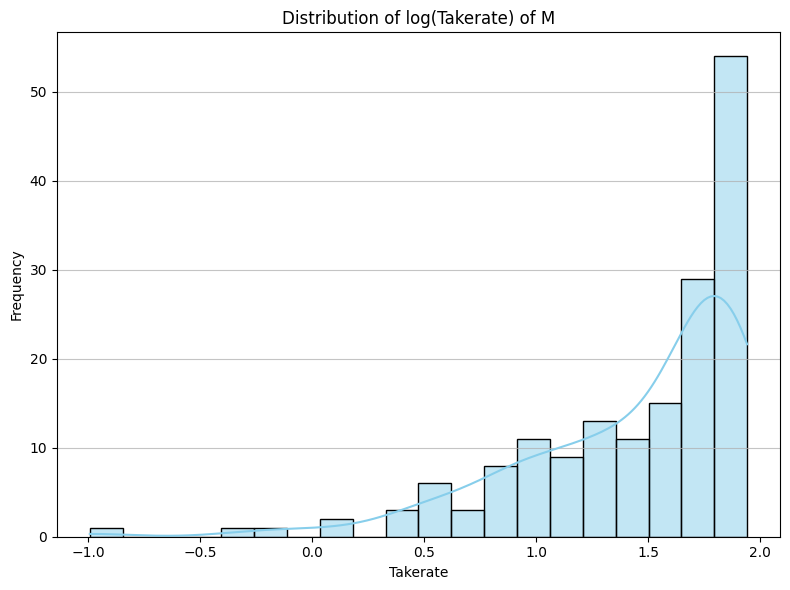

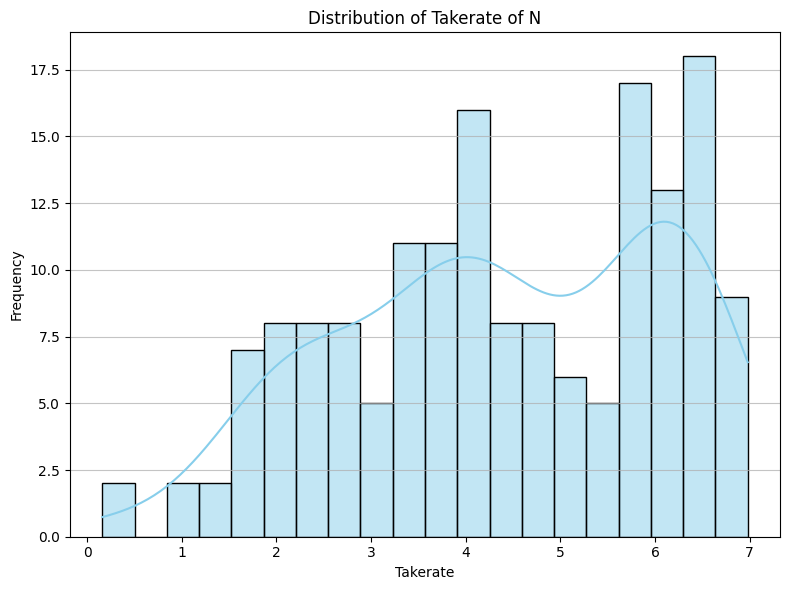

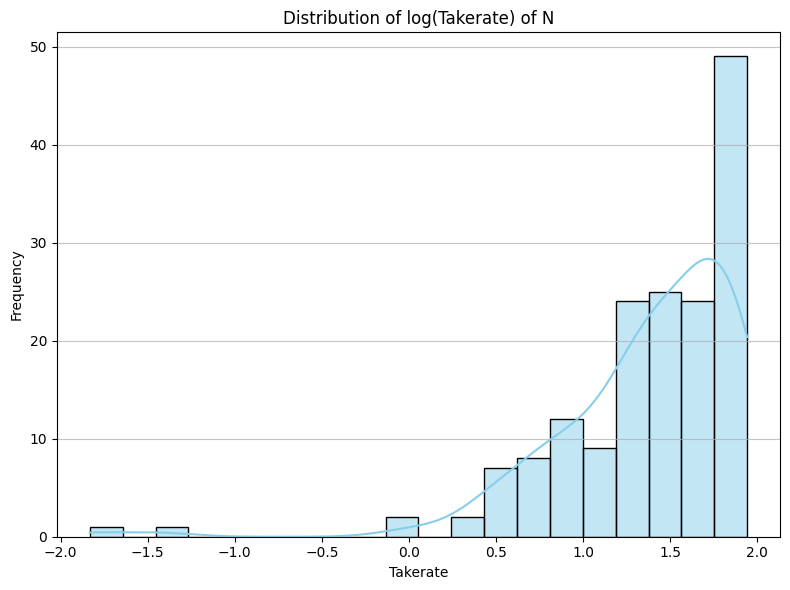

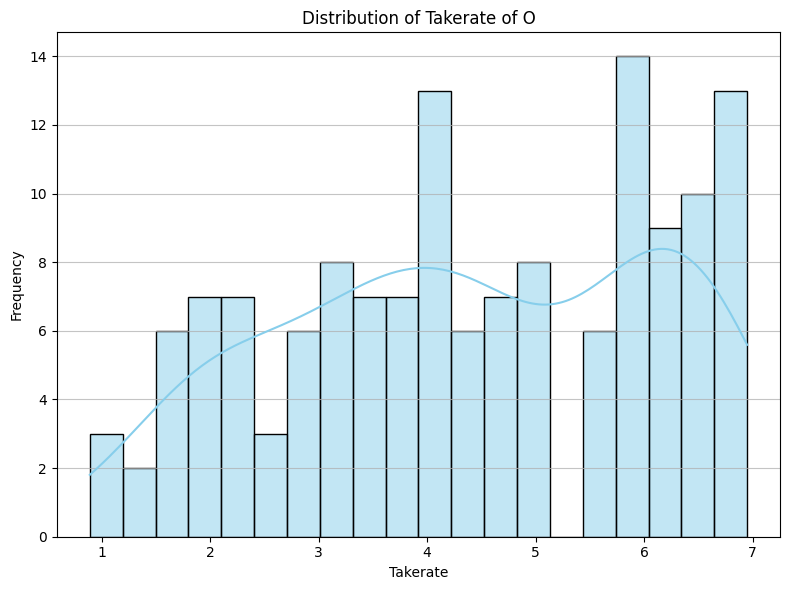

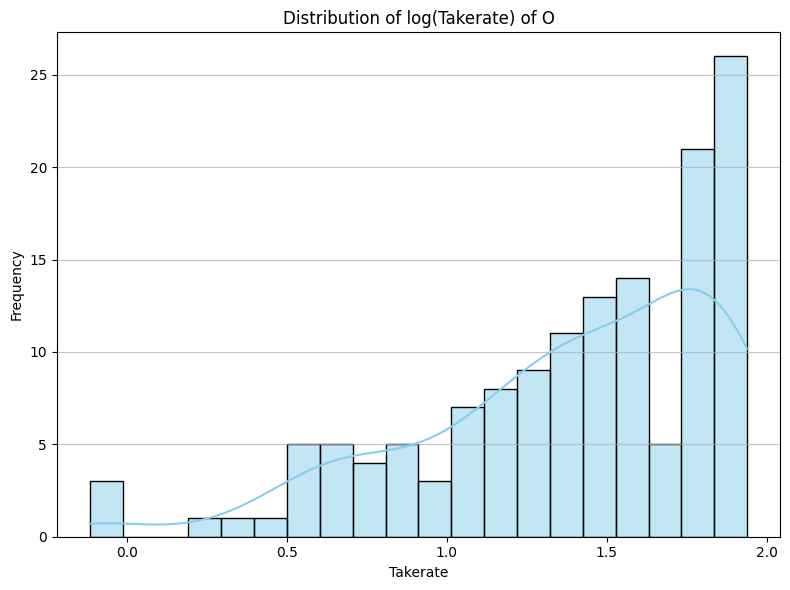

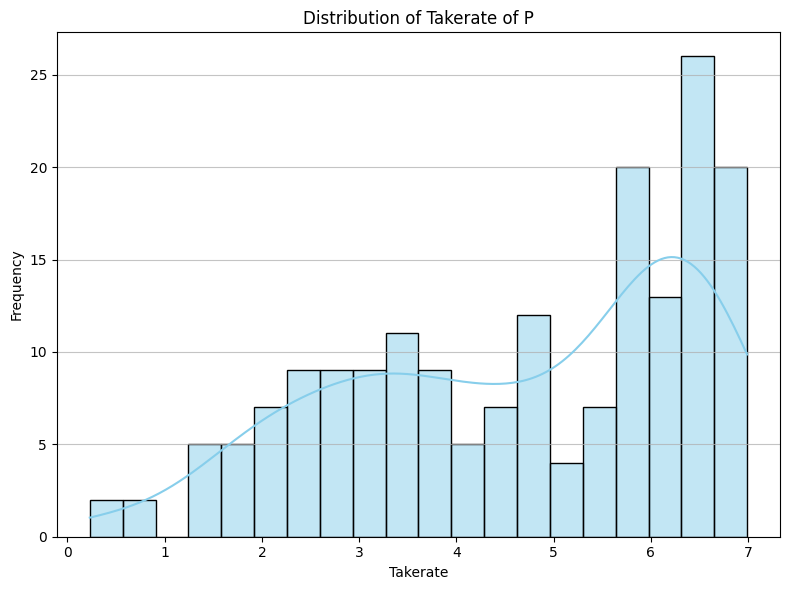

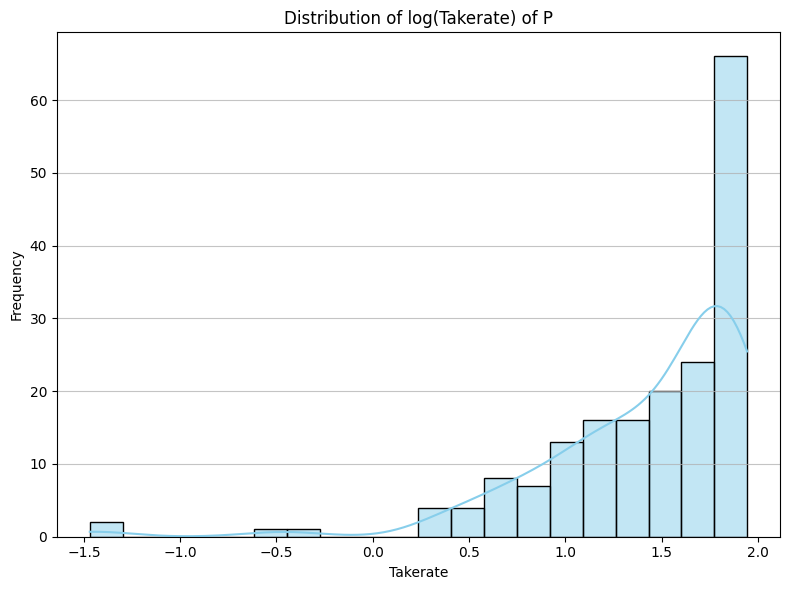

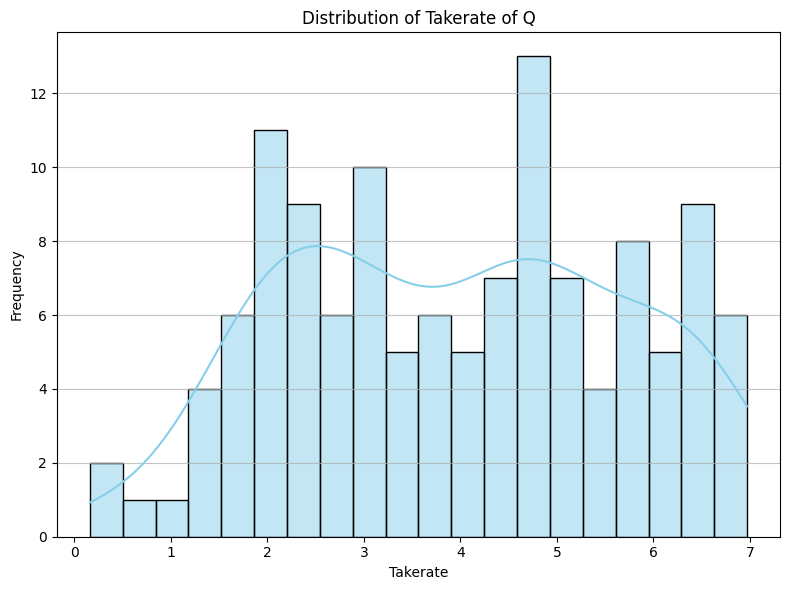

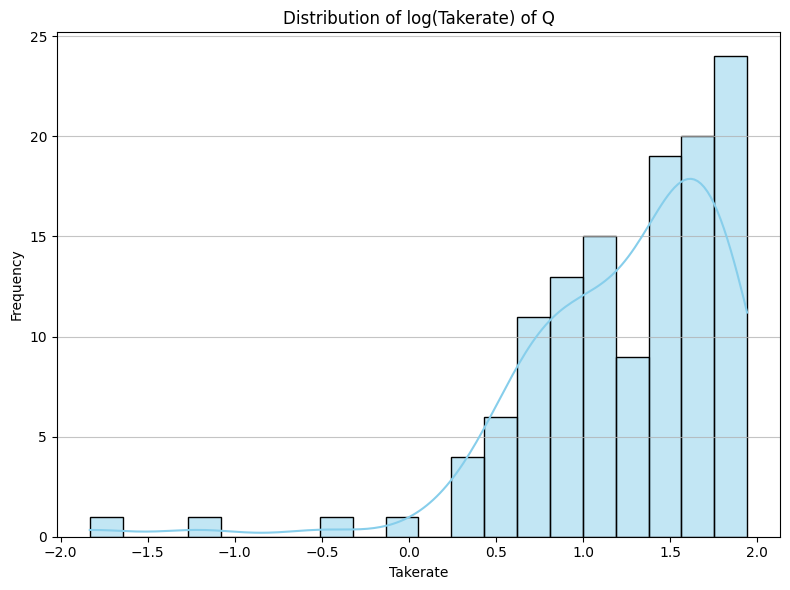

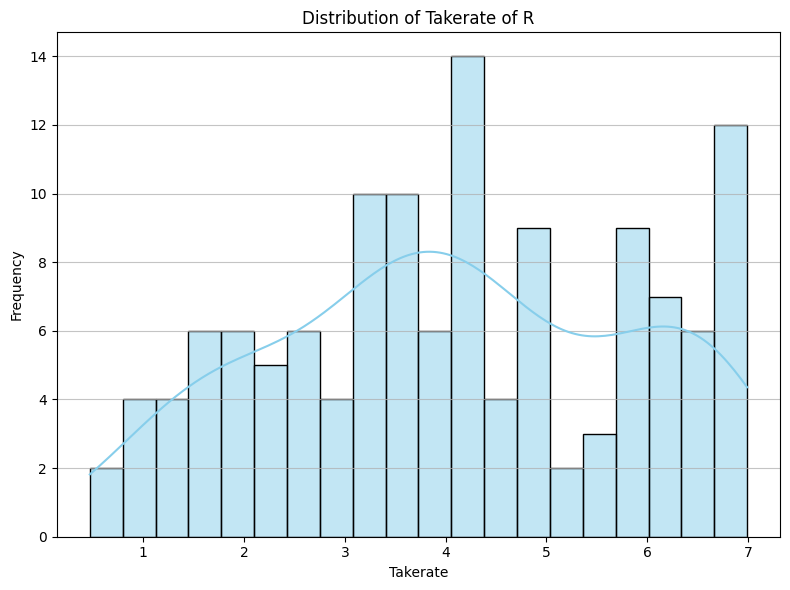

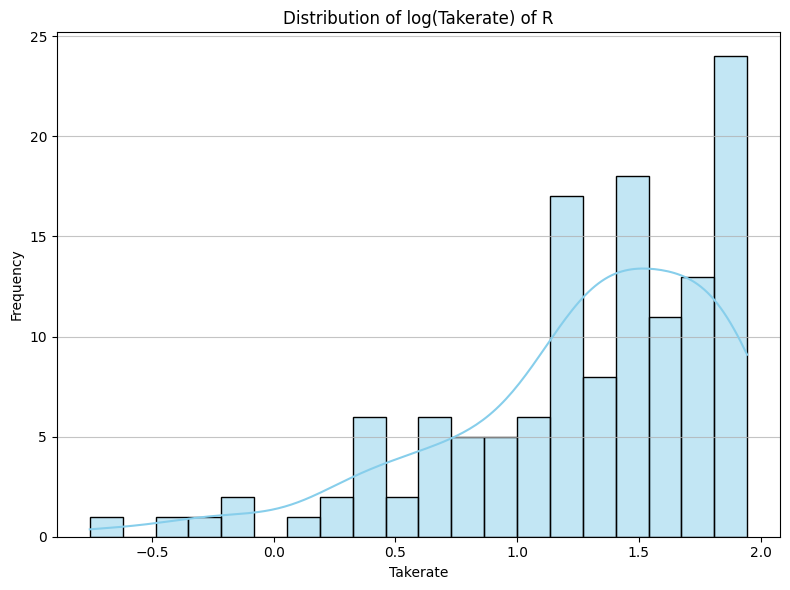

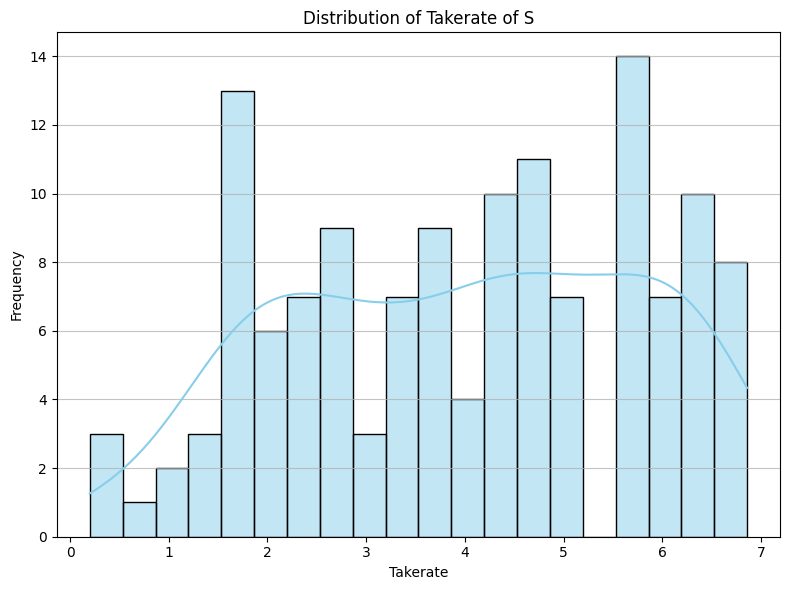

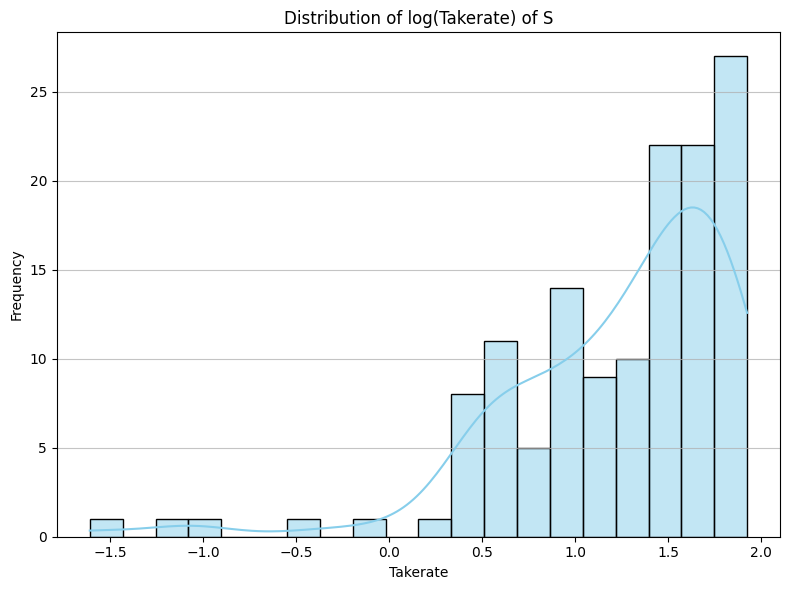

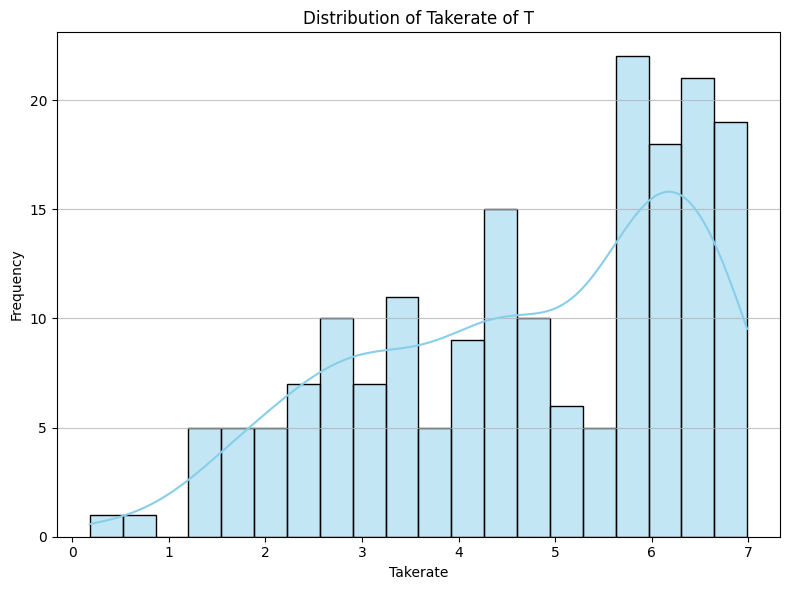

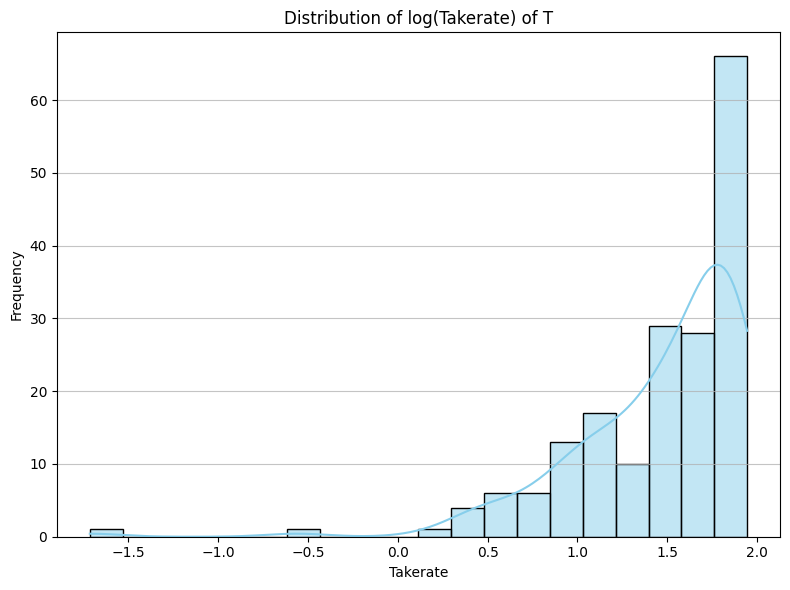

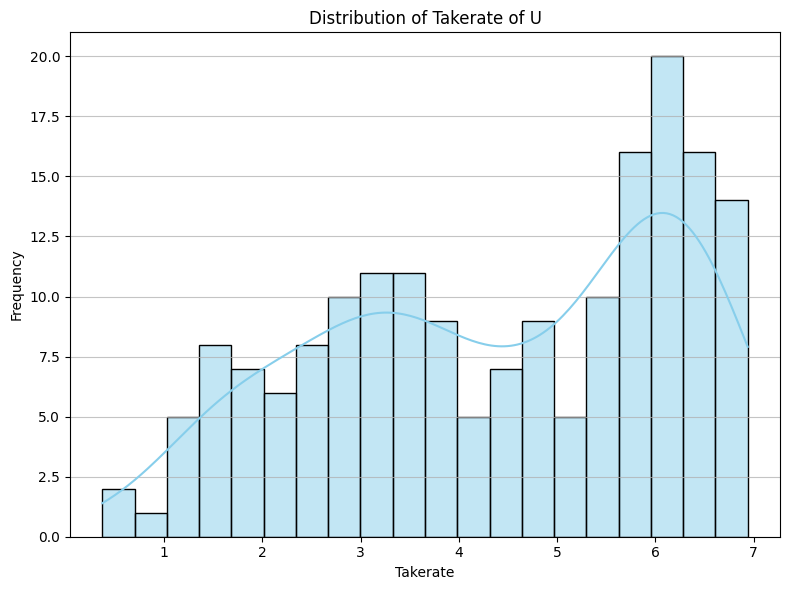

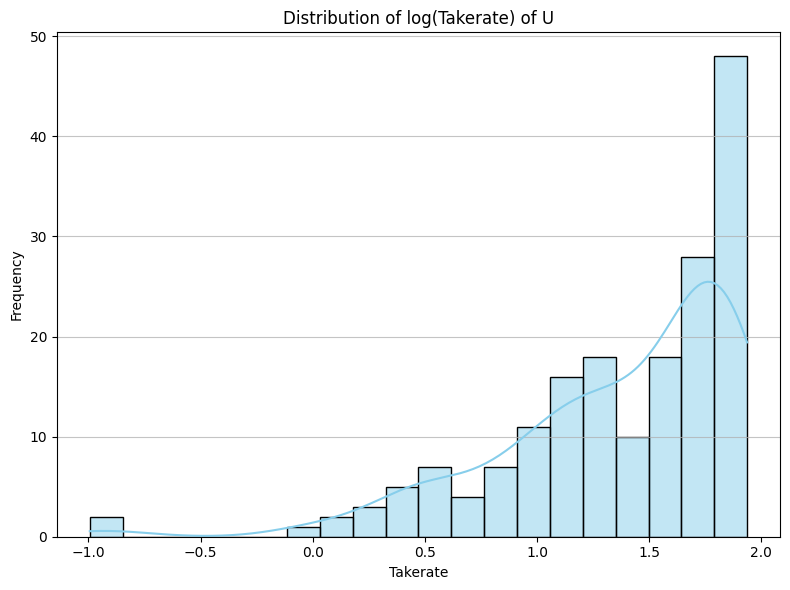

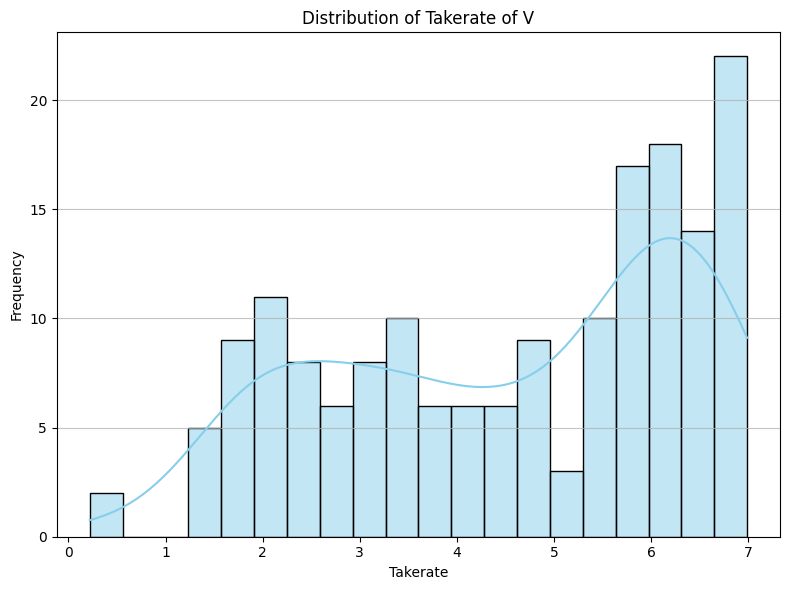

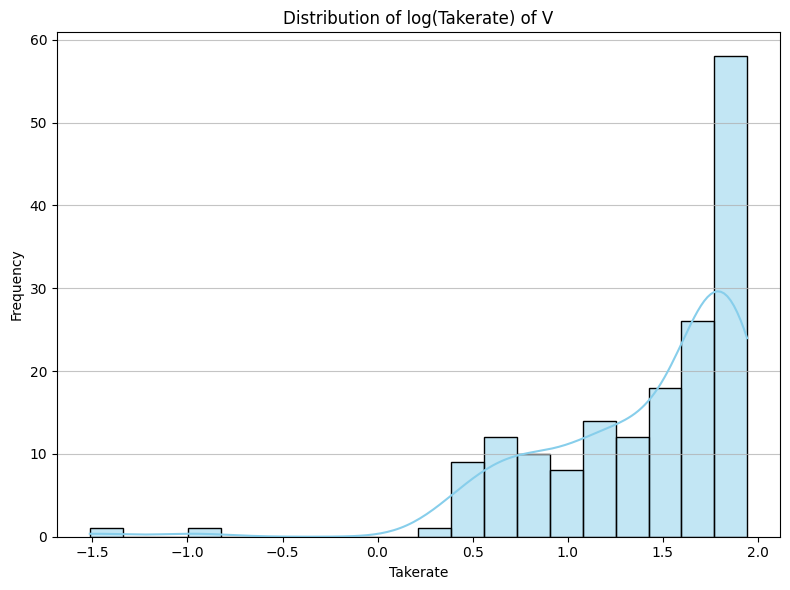

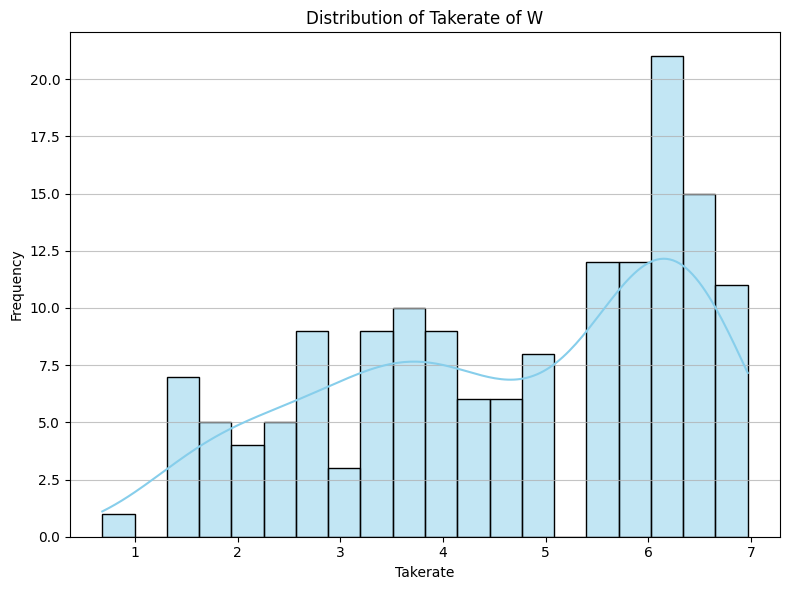

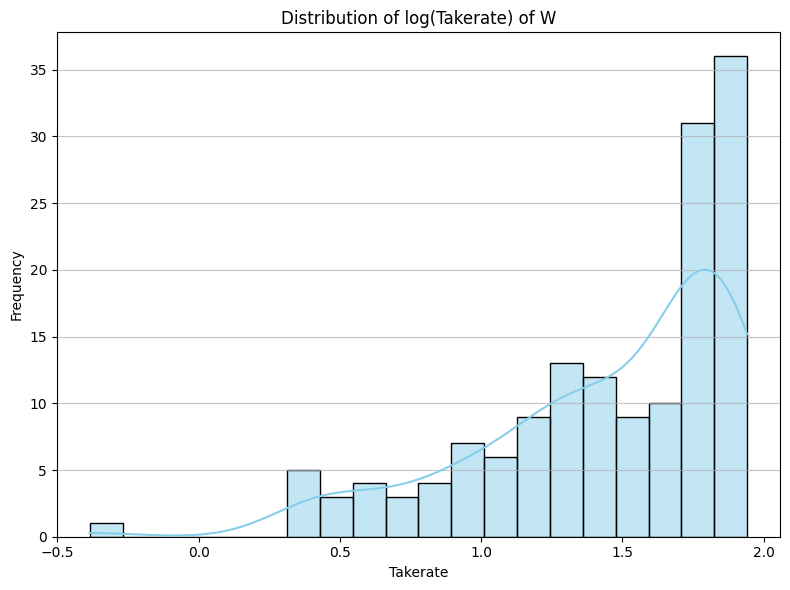

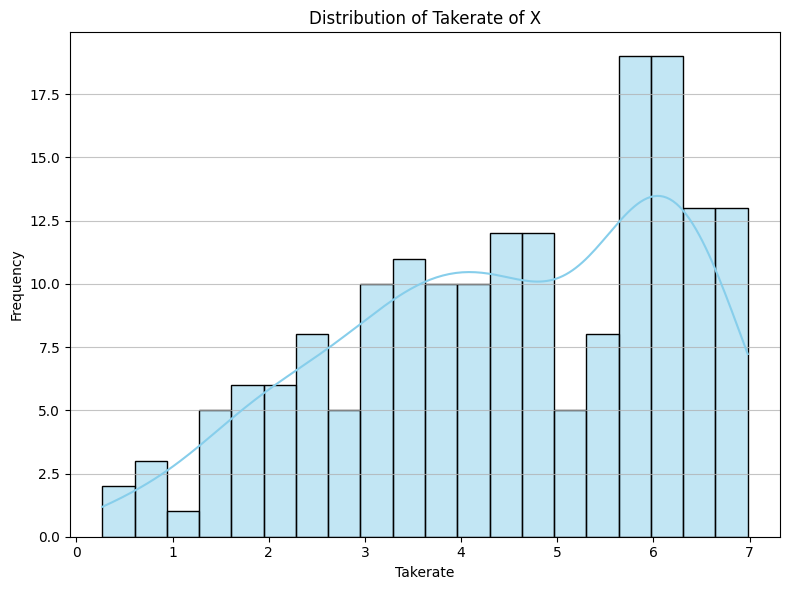

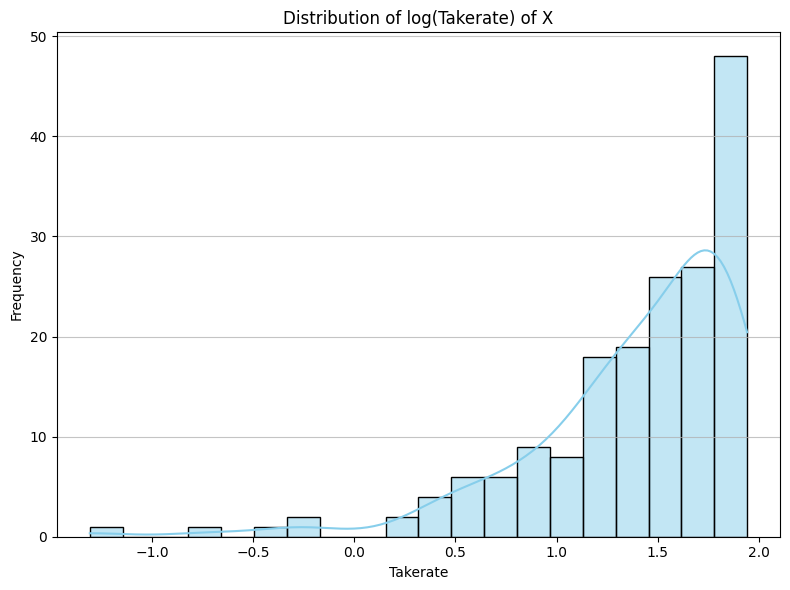

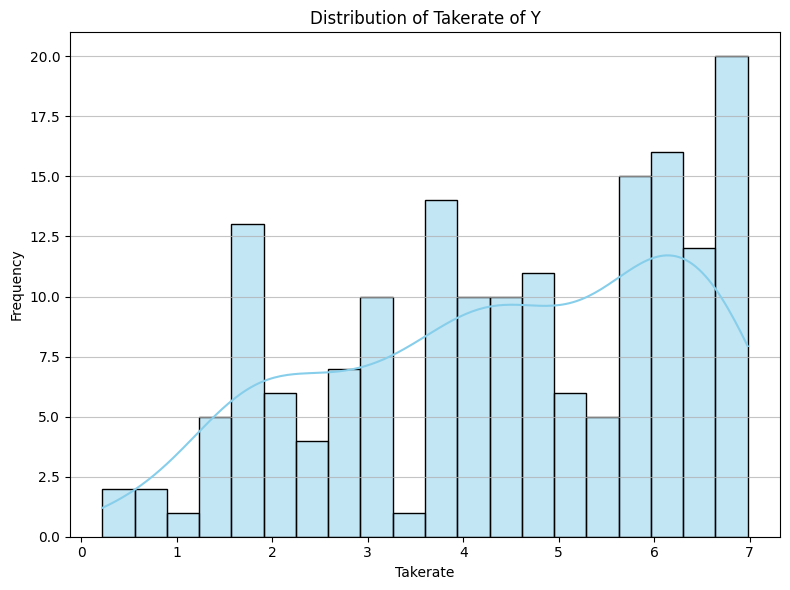

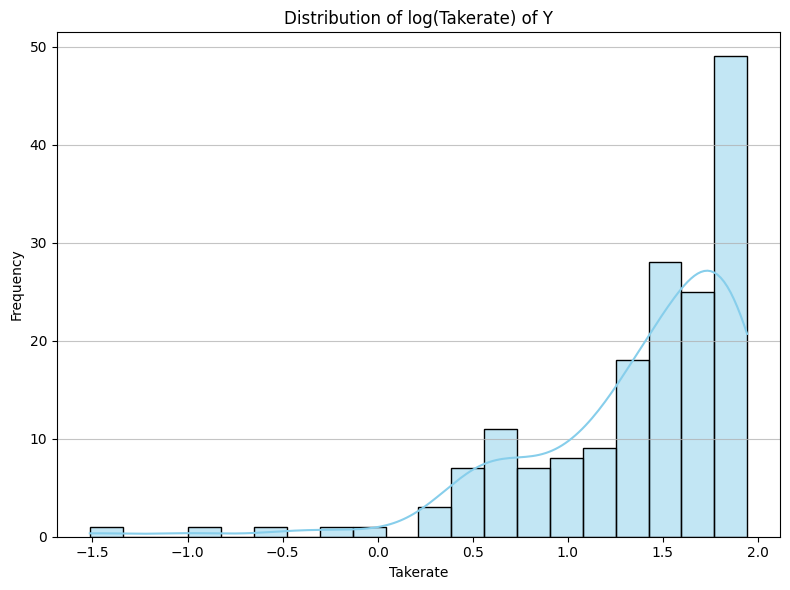

In [21]:
for key, value in industry_dict.items():
    take_rate = value.orderBy(TAKE_RATE, ascending = False)
    distribution_takerate(key, take_rate)
    distribution_takerate_log(key, take_rate)


From the above graphs, we can note that the distribution of the industries seems bimodel and the distribution with log tranformation are skewed. Hence we can use the distribution without the log tranformation to find the mean and median 

In [22]:
# finding the mean and median takerate of each industry and saving to a dictionary

take_rate_mean = {}
take_rate_median = {}
for key, value in industry_dict.items():
    take_rate = value.orderBy(TAKE_RATE, ascending = False)
    take_rate_mean[key] = take_rate.agg(mean(take_rate[TAKE_RATE])).collect()[0][0]
    take_rate_median[key] = take_rate.agg(median(take_rate[TAKE_RATE])).collect()[0][0]


In [23]:
# converting the dict to a pandas dataframe to save as a csv file

takerate_mean_median = pd.DataFrame({MAPPED_INDUSTRY: list(take_rate_mean.keys()), 'Mean_Takerate': list(take_rate_mean.values()), 'Median_Takerate': list(take_rate_median.values())})

In [24]:
takerate_mean_median.sort_values(by='Mean_Takerate', ascending=False)

,MappedIndustry,Mean_Takerate,Median_Takerate
19,T,4.730495,4.940
12,M,4.697425,5.080
15,P,4.655165,4.945
22,W,4.646405,4.920
5,F,4.645385,5.050
10,K,4.616571,5.010
1,B,4.592973,4.770
9,J,4.585856,4.620
21,V,4.582059,4.860
23,X,4.482978,4.625


From the above table, the mean and median for the distribution without log transformation is very close in value. This does signify they have a normal distribution.

In [25]:
takerate_mean_median.to_csv(PREFIX + CURATED_TAKERATE_PATH, index=False)
